In [1]:
# Import required libraries for optimization, data processing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
# Define the data folder path and load all JSON parameter files
# Using question_1c data which includes battery storage parameters
folder_path = './data/question_1c'
file_type = ".json"

# Load appliance parameters (PV, load, and battery specifications)
with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

# Load bus/grid parameters (tariffs, limits, prices)
with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

# Load consumer parameters
with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

# Load DER (Distributed Energy Resource) production profiles
with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

# Load usage preferences (reference load profile and battery preferences)
with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)

In [3]:
# Extract system parameters from bus data
# These parameters define grid connection constraints and pricing
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']  # Grid import tariff (DKK/kWh)
tau_exp = bus_data['export_tariff_DKK/kWh']  # Grid export tariff (DKK/kWh)
max_import = bus_data['max_import_kW']  # Maximum grid import capacity (kW)
max_export = bus_data['max_export_kW']  # Maximum grid export capacity (kW)
electricity_prices = bus_data['energy_price_DKK_per_kWh']  # Hourly electricity prices (DKK/kWh)

In [4]:
# Extract PV (Photovoltaic) parameters
# Calculate hourly PV production by combining capacity and production profile
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']  # PV system capacity (kW)
pv_profile = DER_production[0]['hourly_profile_ratio']  # Hourly production ratio (0-1)
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile]  # Actual PV production per hour (kW)

In [5]:
# Extract load parameters and reference profile
# The reference profile D_ref represents the consumer's preferred load pattern
load_data = appliance_params['load'][0]
D_max = load_data['max_load_kWh_per_hour']  # Maximum power consumption per hour (kW)
D_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio']  # Reference profile ratio (0-1)
D_ref = [D_max * ratio for ratio in D_ref_ratio]  # Reference load profile (kW)

In [6]:
# Extract battery storage parameters
# These define the BASE battery specifications that will be scaled by gamma
Battery_data = appliance_params['storage'][0]
Battery_preferences = usage_preference[0]['storage_preferences'][0]

# Base battery capacity and power limits (will be multiplied by gamma for optimal sizing)
Batt_cap = Battery_data['storage_capacity_kWh']  # Base battery capacity (kWh)
Batt_max_ch_power = Battery_data['max_charging_power_ratio'] * Batt_cap  # Base max charging power (kW)
Batt_max_dis_power = Battery_data['max_discharging_power_ratio'] * Batt_cap  # Base max discharging power (kW)

# Battery efficiency parameters
Batt_charging_eff = Battery_data['charging_efficiency']  # Charging efficiency (0-1)
Batt_discharging_eff = Battery_data['discharging_efficiency']  # Discharging efficiency (0-1)

# Battery state of charge (SOC) constraints (scaled by gamma)
Batt_initial_soc = Battery_preferences['initial_soc_ratio'] * Batt_cap  # Initial SOC ratio
Batt_final_soc = Battery_preferences['final_soc_ratio'] * Batt_cap  # Required final SOC ratio

# Battery economic parameters for sizing optimization
c_batt = 1200  # Battery cost coefficient (DKK/kWh) - capital cost per unit capacity
N_batt = 10 * 365  # Battery lifetime in days (10 years × 365 days)

In [7]:
# Display base battery specifications for reference
# These values will be scaled by the optimization variable gamma
print(f"Battery capacity: {Batt_cap} kWh")
print(f"Max charging power: {Batt_max_ch_power} kW")
print(f"Max discharging power: {Batt_max_dis_power} kW")

Battery capacity: 6.0 kWh
Max charging power: 0.8999999999999999 kW
Max discharging power: 1.7999999999999998 kW


In [8]:
# Temporal parameters
# Define the time horizon for optimization (24 hours in a day)
T = len(electricity_prices)  # Number of time periods (24 hours)
Times = range(T)  # Time index: 0 to 23

# Discomfort penalty parameter
# Alpha controls the trade-off between cost minimization and comfort (following D_ref)
alpha = 0.5

In [9]:
# Create Gurobi optimization model for battery sizing
# This model optimizes BOTH battery size (gamma) AND energy scheduling
model = gp.Model("Energy_Optimization")

# NEW: Battery sizing decision variable
# gamma_batt is the scaling factor for battery capacity (gamma=1 means full base capacity)
# gamma=0 means no battery, gamma>1 means larger than base capacity
gamma_batt = model.addVar(lb=0, name="gamma_batt")  # Battery linear scaling factor

# Standard decision variables with FIXED upper bounds (not battery-related)
D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")  # Grid import (kW)
P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")  # Grid export (kW)
L_t = model.addVars(Times, lb=0, name="L_t")  # Discomfort - deviation from reference load (kW)

# Battery operation variables - NO upper bounds here, controlled by gamma_batt constraints
# Upper bounds are dynamic: P_batt_ch[t] <= Batt_max_ch_power * gamma_batt (see constraints)
P_batt_ch = model.addVars(Times, lb=0, name="P_batt_ch")  # Battery charging power (kW)
P_batt_dis = model.addVars(Times, lb=0, name="P_batt_dis")  # Battery discharging power (kW)
SOC = model.addVars(Times, lb=0, name="SOC")  # State of Charge (kWh)

Set parameter Username
Set parameter LicenseID to value 2617496
Academic license - for non-commercial use only - expires 2026-02-03
Set parameter LicenseID to value 2617496
Academic license - for non-commercial use only - expires 2026-02-03


In [10]:
# Objective function: Minimize total cost including battery investment
# Total Cost = Energy Cost + Discomfort Cost + Daily Battery Cost
# 
# 1. Energy Cost = Import Cost - Export Revenue
#    - Import Cost = P_imp * (tau_imp + price)
#    - Export Revenue = P_exp * (price - tau_exp)
# 
# 2. Discomfort Cost = alpha * sum(L_t)
# 
# 3. Daily Battery Cost = c_batt * (gamma_batt * Batt_cap) / N_batt
#    - Annualized capital cost divided by lifetime in days
#    - Scales linearly with chosen capacity (gamma_batt)
model.setObjective(
    gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                P_exp_t[t] * (electricity_prices[t] - tau_exp) + alpha * L_t[t] for t in Times) +
                c_batt * (gamma_batt * Batt_cap) / N_batt,
    GRB.MINIMIZE)

In [11]:
# Add constraints to the optimization model

# 1. Curtailment constraint - cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# 2. Discomfort constraints - model absolute deviation from reference load
# L_t >= |D_t - D_ref[t]| using two linear inequalities
discomfort_constraint_1 = [
	model.addLConstr(L_t[t] >= D_t[t] - D_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(L_t[t] >= -(D_t[t] - D_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

# 3. Power balance constraint - energy flow balance at each hour including battery
# Grid import - Grid export - Battery charge + Battery discharge = Load - PV production + Curtailment
power_balance_constraint = [
	model.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

# 4. Battery sizing constraints - scale battery power and capacity with gamma_batt
# These constraints link battery operation variables to the sizing decision variable gamma_batt

# 4a. Charging power limit - scales with battery size
battery_charge_limit = [
	model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power * gamma_batt, name=f"batt_ch_limit_{t}")
	for t in Times
]

# 4b. Discharging power limit - scales with battery size
battery_discharge_limit = [
	model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power * gamma_batt, name=f"batt_dis_limit_{t}")
	for t in Times
]

# 4c. State of charge limit - scales with battery size
battery_soc_limit = [
	model.addLConstr(SOC[t] <= Batt_cap * gamma_batt, name=f"soc_limit_{t}")
	for t in Times
]

# 5. Battery State of Charge (SOC) dynamics

# 5a. Initial SOC constraint (t=0) - scaled by gamma
# Starting SOC proportional to battery size plus first hour charge/discharge
SOC_0 = [
    model.addConstr(SOC[0] == Batt_initial_soc * gamma_batt + P_batt_ch[0]*Batt_charging_eff - P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
]

# 5b. SOC evolution constraint (t>0)
# SOC(t) = SOC(t-1) + charging energy - discharging energy
SOC_dynamics = [
    model.addLConstr(SOC[t] == (SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - P_batt_dis[t]/Batt_discharging_eff), name=f"SOC_dynamics_{t}")
    for t in Times if t > 0
]

# 5c. Final SOC constraint - scaled by gamma
# Ensures battery is sufficiently charged at end of day (proportional to size)
SOC_end = [
    model.addLConstr(SOC[T-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
]

# 6. Daily energy constraint - total daily load must equal reference total
# This ensures the same amount of energy is consumed, just potentially at different times
daily_energy_constraint = model.addLConstr(
    gp.quicksum(D_t[t] for t in Times) == sum(D_ref), 
    name="daily_energy_constraint"
)

In [12]:
# Solve the optimization problem
# Gurobi will find the optimal battery size (gamma) AND energy scheduling
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 194 rows, 193 columns and 530 nonzeros
Model fingerprint: 0xbac64d1e
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 194 rows, 193 columns and 530 nonzeros
Model fingerprint: 0xbac64d1e
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
Presolve removed 25 rows and 10 columns
Presolve time: 0.01s
Presolved: 169 rows, 183 columns, 497 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1030000e+04  

In [13]:
# Display optimization results including optimal battery sizing
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    
    # Display optimal battery sizing results
    print("\n" + "="*70)
    print("OPTIMAL BATTERY SIZING")
    print("="*70)
    print(f"Scaling factor (gamma): {gamma_batt.X:.4f}")
    print(f"Optimal battery capacity: {gamma_batt.X * Batt_cap:.2f} kWh (base: {Batt_cap:.2f} kWh)")
    print(f"Optimal max charging power: {gamma_batt.X * Batt_max_ch_power:.2f} kW (base: {Batt_max_ch_power:.2f} kW)")
    print(f"Optimal max discharging power: {gamma_batt.X * Batt_max_dis_power:.2f} kW (base: {Batt_max_dis_power:.2f} kW)")
    print(f"Daily battery cost: {c_batt * (gamma_batt.X * Batt_cap) / N_batt:.4f} DKK")
    print("="*70)
    
    # Display hourly operation details
    print("\nHour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]")
    for t in Times:
        print(f"{t:4d} | {D_t[t].X:9.2f} | {C_t[t].X:15.2f} | {P_imp_t[t].X:15.2f} | {P_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f} | {SOC[t].X:18.2f} | {P_batt_ch[t].X:18.2f} | {P_batt_dis[t].X:20.2f}")


Optimal solution found:
Total cost: 28.98 DKK

OPTIMAL BATTERY SIZING
Scaling factor (gamma): 1.0405
Optimal battery capacity: 6.24 kWh (base: 6.00 kWh)
Optimal max charging power: 0.94 kW (base: 0.90 kW)
Optimal max discharging power: 1.87 kW (base: 1.80 kW)
Daily battery cost: 2.0525 DKK

Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]
   0 |      0.17 |            0.00 |            0.17 |            0.00 |               0.00 |                      1.10 |               3.12 |               0.00 |                 0.00
   1 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.05 |               3.12 |               0.00 |                 0.00
   2 |      0.12 |            0.00 |            0.27 |            0.00 |               0.00 |                      1.00 |               3

# Question 2.b.iv - Battery Profitability Analysis

## Consumer Flexibility Analysis

We analyze how optimal battery sizing varies with consumer flexibility (α parameter).

**Three Consumer Types:**
- **Highly Flexible (α = 0.1):** Cost-sensitive, willing to shift consumption
- **Moderately Flexible (α = 0.5):** Balanced cost-comfort tradeoff
- **Inflexible (α = 2.0):** Comfort-prioritizing, rigid consumption patterns

**Hypothesis:** Inflexible consumers benefit more from battery storage as it provides the flexibility they cannot achieve through load shifting.

In [14]:
# Function to solve battery sizing optimization for a given consumer type (alpha)
# This enables sensitivity analysis across different consumer flexibility levels
def solve_battery_sizing(alpha_value, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                         D_max_val, D_ref_vals, Batt_cap_val, Batt_max_ch, Batt_max_dis,
                         Batt_eff_ch, Batt_eff_dis, Batt_init_soc, Batt_final_soc,
                         c_batt_val, N_batt_val, max_imp, max_exp):
    """
    Solve battery sizing optimization for given alpha (discomfort weight)
    
    Args:
        alpha_value: Discomfort penalty parameter (higher = less flexible consumer)
        pv_prod: Hourly PV production profile (kW)
        elec_prices: Hourly electricity prices (DKK/kWh)
        tau_imp_val: Import tariff (DKK/kWh)
        tau_exp_val: Export tariff (DKK/kWh)
        D_max_val: Maximum load per hour (kW)
        D_ref_vals: Reference load profile (kW)
        Batt_cap_val: Base battery capacity (kWh)
        Batt_max_ch: Base max charging power (kW)
        Batt_max_dis: Base max discharging power (kW)
        Batt_eff_ch: Charging efficiency (0-1)
        Batt_eff_dis: Discharging efficiency (0-1)
        Batt_init_soc: Initial SOC ratio
        Batt_final_soc: Final SOC ratio
        c_batt_val: Battery cost (DKK/kWh)
        N_batt_val: Battery lifetime (days)
        max_imp: Maximum grid import (kW)
        max_exp: Maximum grid export (kW)
    
    Returns: 
        dict with optimization results including optimal gamma and cost breakdown
    """
    Times = range(len(elec_prices))
    
    # Create model
    m = gp.Model(f"Battery_Sizing_alpha_{alpha_value}")
    m.setParam('OutputFlag', 0)  # Suppress solver output
    
    # Decision variables
    gamma_batt = m.addVar(lb=0, name="gamma_batt")
    D_t = m.addVars(Times, lb=0, ub=D_max_val, name="D_t")
    C_t = m.addVars(Times, lb=0, name="C_t")
    P_imp_t = m.addVars(Times, lb=0, ub=max_imp, name="P_imp_t")
    P_exp_t = m.addVars(Times, lb=0, ub=max_exp, name="P_exp_t")
    L_t = m.addVars(Times, lb=0, name="L_t")
    P_batt_ch = m.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = m.addVars(Times, lb=0, name="P_batt_dis")
    SOC = m.addVars(Times, lb=0, name="SOC")
    
    # Objective function: minimize energy cost + discomfort cost + battery cost
    m.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    P_exp_t[t] * (elec_prices[t] - tau_exp_val) + 
                    alpha_value * L_t[t] for t in Times) +
                    c_batt_val * (gamma_batt * Batt_cap_val) / N_batt_val,
        GRB.MINIMIZE
    )
    
    # Add all constraints
    for t in Times:
        # Curtailment constraint
        m.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        
        # Discomfort constraints
        m.addLConstr(L_t[t] >= D_t[t] - D_ref_vals[t], name=f"discomfort_1_{t}")
        m.addLConstr(L_t[t] >= -(D_t[t] - D_ref_vals[t]), name=f"discomfort_2_{t}")
        
        # Power balance
        m.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                     D_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
        
        # Battery sizing constraints (link operation to gamma)
        m.addLConstr(P_batt_ch[t] <= Batt_max_ch * gamma_batt, name=f"batt_ch_limit_{t}")
        m.addLConstr(P_batt_dis[t] <= Batt_max_dis * gamma_batt, name=f"batt_dis_limit_{t}")
        m.addLConstr(SOC[t] <= Batt_cap_val * gamma_batt, name=f"soc_limit_{t}")
    
    # Initial SOC
    m.addConstr(SOC[0] == Batt_init_soc * gamma_batt + 
                P_batt_ch[0] * Batt_eff_ch - P_batt_dis[0] / Batt_eff_dis, 
                name="SOC_0")
    
    # SOC dynamics
    for t in Times:
        if t > 0:
            m.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t] * Batt_eff_ch - 
                         P_batt_dis[t] / Batt_eff_dis, name=f"SOC_dynamics_{t}")
    
    # Final SOC
    m.addLConstr(SOC[len(Times)-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
    
    # Daily energy constraint
    m.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref_vals), 
                 name="daily_energy_constraint")
    
    # Solve
    m.optimize()
    
    # Extract and return results if optimal solution found
    if m.status == GRB.OPTIMAL:
        # Calculate cost components separately
        energy_cost = sum(P_imp_t[t].X * (tau_imp_val + elec_prices[t]) - 
                         P_exp_t[t].X * (elec_prices[t] - tau_exp_val) for t in Times)
        discomfort_cost = alpha_value * sum(L_t[t].X for t in Times)
        battery_cost = c_batt_val * (gamma_batt.X * Batt_cap_val) / N_batt_val
        
        return {
            'alpha': alpha_value,
            'gamma': gamma_batt.X,
            'optimal_capacity': gamma_batt.X * Batt_cap_val,
            'total_cost': m.objVal,
            'energy_cost': energy_cost,
            'discomfort_cost': discomfort_cost,
            'battery_cost': battery_cost,
            'total_grid_import': sum(P_imp_t[t].X for t in Times),
            'total_grid_export': sum(P_exp_t[t].X for t in Times),
            'total_discomfort': sum(L_t[t].X for t in Times),
            'status': 'OPTIMAL'
        }
    else:
        return {
            'alpha': alpha_value,
            'gamma': None,
            'status': f'FAILED: {m.status}'
        }

In [15]:
# Run battery sizing optimization for three consumer types
# Tests how optimal battery size varies with consumer flexibility

# Define three consumer types with different flexibility levels
alpha_values = [0.1, 0.5, 2.0]
consumer_types = ['Highly Flexible', 'Moderately Flexible', 'Inflexible']

# Store results for analysis
results = []

print("="*80)
print("OPTIMAL BATTERY SIZING FOR DIFFERENT CONSUMER TYPES")
print("="*80)

# Solve for each consumer type
for alpha_val, consumer_type in zip(alpha_values, consumer_types):
    print(f"\nSolving for {consumer_type} (α = {alpha_val})...")
    
    result = solve_battery_sizing(
        alpha_value=alpha_val,
        pv_prod=pv_prod_hourly,
        elec_prices=electricity_prices,
        tau_imp_val=tau_imp,
        tau_exp_val=tau_exp,
        D_max_val=D_max,
        D_ref_vals=D_ref,
        Batt_cap_val=Batt_cap,
        Batt_max_ch=Batt_max_ch_power,
        Batt_max_dis=Batt_max_dis_power,
        Batt_eff_ch=Batt_charging_eff,
        Batt_eff_dis=Batt_discharging_eff,
        Batt_init_soc=Batt_initial_soc,
        Batt_final_soc=Batt_final_soc,
        c_batt_val=c_batt,
        N_batt_val=N_batt,
        max_imp=max_import,
        max_exp=max_export
    )
    
    result['consumer_type'] = consumer_type
    results.append(result)
    
    # Display results
    if result['status'] == 'OPTIMAL':
        print(f"  ✓ Optimal gamma: {result['gamma']:.4f}")
        print(f"    Battery capacity: {result['optimal_capacity']:.2f} kWh")
        print(f"    Total cost: {result['total_cost']:.2f} DKK")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

OPTIMAL BATTERY SIZING FOR DIFFERENT CONSUMER TYPES

Solving for Highly Flexible (α = 0.1)...
  ✓ Optimal gamma: 0.0000
    Battery capacity: 0.00 kWh
    Total cost: 23.35 DKK

Solving for Moderately Flexible (α = 0.5)...
  ✓ Optimal gamma: 1.0405
    Battery capacity: 6.24 kWh
    Total cost: 28.98 DKK

Solving for Inflexible (α = 2.0)...
  ✓ Optimal gamma: 1.5667
    Battery capacity: 9.40 kWh
    Total cost: 29.25 DKK

SUMMARY
  ✓ Optimal gamma: 0.0000
    Battery capacity: 0.00 kWh
    Total cost: 23.35 DKK

Solving for Moderately Flexible (α = 0.5)...
  ✓ Optimal gamma: 1.0405
    Battery capacity: 6.24 kWh
    Total cost: 28.98 DKK

Solving for Inflexible (α = 2.0)...
  ✓ Optimal gamma: 1.5667
    Battery capacity: 9.40 kWh
    Total cost: 29.25 DKK

SUMMARY


In [16]:
# Display results in a clean summary table
# Analyzes optimal battery sizing across different consumer flexibility levels
import pandas as pd

# Create DataFrame for easy analysis
df_results = pd.DataFrame(results)

# Display key metrics in formatted table
print(f"\n{'Consumer Type':<25} | {'Alpha':>8} | {'Gamma':>8} | {'Battery (kWh)':>15} | {'Total Cost (DKK)':>18}")
print("-" * 90)

for _, row in df_results.iterrows():
    if row['status'] == 'OPTIMAL':
        print(f"{row['consumer_type']:<25} | {row['alpha']:>8.1f} | {row['gamma']:>8.4f} | {row['optimal_capacity']:>15.2f} | {row['total_cost']:>18.2f}")

# Print key insights from the analysis
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n1. Optimal battery sizing:")
print(f"   - Highly Flexible:     {df_results.iloc[0]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[0]['gamma']:.4f})")
print(f"   - Moderately Flexible: {df_results.iloc[1]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[1]['gamma']:.4f})")
print(f"   - Inflexible:          {df_results.iloc[2]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[2]['gamma']:.4f})")

# Calculate relative sizing between extreme cases
gamma_flexible = df_results.iloc[0]['gamma']
gamma_inflexible = df_results.iloc[2]['gamma']
ratio = gamma_inflexible / gamma_flexible if gamma_flexible > 0.001 else float('inf')

print(f"\n2. Inflexible consumers need {ratio:.1f}x more battery capacity than flexible consumers")

# Display detailed cost breakdown for each consumer type
print(f"\n3. Cost breakdown:")
for _, row in df_results.iterrows():
    if row['status'] == 'OPTIMAL':
        print(f"\n   {row['consumer_type']}:")
        print(f"     - Energy cost:     {row['energy_cost']:>10.2f} DKK")
        print(f"     - Discomfort cost: {row['discomfort_cost']:>10.2f} DKK")
        print(f"     - Battery cost:    {row['battery_cost']:>10.2f} DKK")
        print(f"     - TOTAL:           {row['total_cost']:>10.2f} DKK")


Consumer Type             |    Alpha |    Gamma |   Battery (kWh) |   Total Cost (DKK)
------------------------------------------------------------------------------------------
Highly Flexible           |      0.1 |   0.0000 |            0.00 |              23.35
Moderately Flexible       |      0.5 |   1.0405 |            6.24 |              28.98
Inflexible                |      2.0 |   1.5667 |            9.40 |              29.25

KEY INSIGHTS

1. Optimal battery sizing:
   - Highly Flexible:     0.00 kWh (γ = 0.0000)
   - Moderately Flexible: 6.24 kWh (γ = 1.0405)
   - Inflexible:          9.40 kWh (γ = 1.5667)

2. Inflexible consumers need infx more battery capacity than flexible consumers

3. Cost breakdown:

   Highly Flexible:
     - Energy cost:          21.28 DKK
     - Discomfort cost:       2.07 DKK
     - Battery cost:          0.00 DKK
     - TOTAL:                23.35 DKK

   Moderately Flexible:
     - Energy cost:          25.74 DKK
     - Discomfort cost:       1.

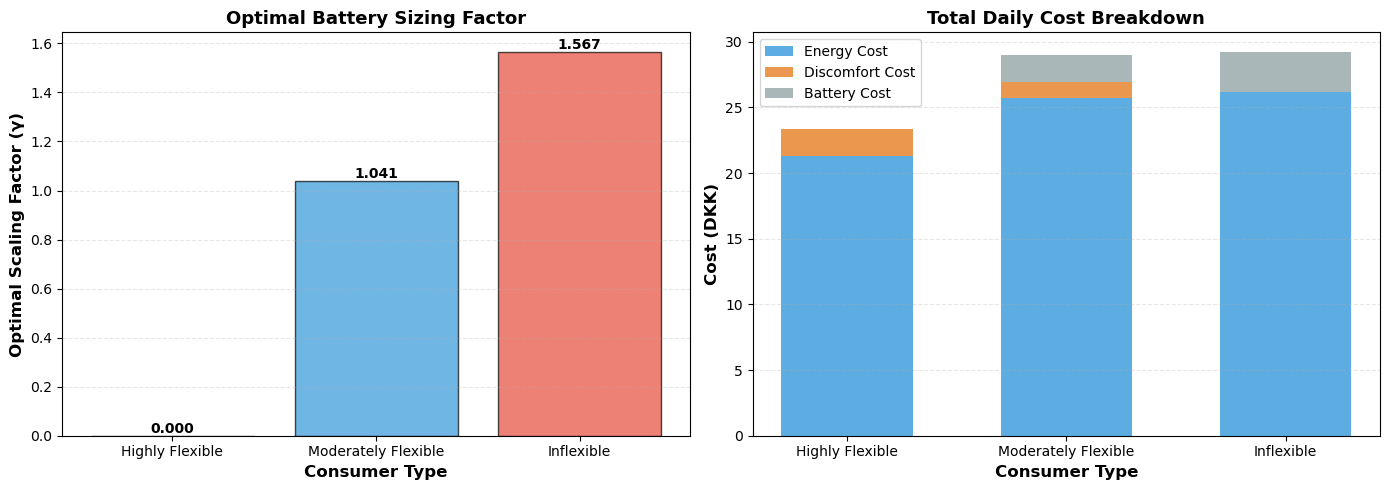

In [17]:
# Visualization: Optimal Battery Sizing by Consumer Type
# Two-panel plot showing gamma values and cost breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Optimal Battery Capacity (gamma)
ax1 = axes[0]
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
bars1 = ax1.bar(consumer_types, [r['gamma'] for r in results], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Optimal Scaling Factor (γ)', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Battery Sizing Factor', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, result in zip(bars1, results):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{result["gamma"]:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Total Cost Breakdown (stacked bar chart)
ax2 = axes[1]
energy_costs = [r['energy_cost'] for r in results]
discomfort_costs = [r['discomfort_cost'] for r in results]
battery_costs = [r['battery_cost'] for r in results]

x_pos = range(len(consumer_types))
width = 0.6

# Create stacked bars
ax2.bar(x_pos, energy_costs, width, label='Energy Cost', color='#3498db', alpha=0.8)
ax2.bar(x_pos, discomfort_costs, width, bottom=energy_costs, 
        label='Discomfort Cost', color='#e67e22', alpha=0.8)
ax2.bar(x_pos, battery_costs, width, 
        bottom=[e+d for e,d in zip(energy_costs, discomfort_costs)],
        label='Battery Cost', color='#95a5a6', alpha=0.8)

ax2.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cost (DKK)', fontsize=12, fontweight='bold')
ax2.set_title('Total Daily Cost Breakdown', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(consumer_types)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
import os
os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
plt.savefig('./Plots/Scenarios 2)/consumer_flexibility_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

## Battery Cost Sensitivity Analysis

W

**Cost Range:** 600 - 1800 DKK/kWh



In [18]:
# Battery cost sensitivity analysis
# Tests how optimal battery sizing responds to changes in capital cost
# Cost range: 600 to 1800 DKK/kWh in steps of 100

c_batt_values = np.arange(600, 1900, 100)  # Battery cost range
alpha_test = [0.1, 0.5, 2.0]  # Three consumer types
consumer_labels = ['Highly Flexible (α=0.1)', 'Moderately Flexible (α=0.5)', 'Inflexible (α=2.0)']

# Store results for each alpha and c_batt combination
sensitivity_results = {alpha: [] for alpha in alpha_test}

print("="*80)
print("BATTERY COST SENSITIVITY ANALYSIS")
print("="*80)
print(f"Testing battery costs from {c_batt_values[0]} to {c_batt_values[-1]} DKK/kWh")
print(f"Consumer types: α = {alpha_test}")
print("="*80)

# Run sensitivity analysis for each consumer type
for alpha_val in alpha_test:
    print(f"\nAnalyzing consumer type alpha = {alpha_val}...")
    
    # Test each battery cost level
    for c_batt_test in c_batt_values:
        result = solve_battery_sizing(
            alpha_value=alpha_val,
            pv_prod=pv_prod_hourly,
            elec_prices=electricity_prices,
            tau_imp_val=tau_imp,
            tau_exp_val=tau_exp,
            D_max_val=D_max,
            D_ref_vals=D_ref,
            Batt_cap_val=Batt_cap,
            Batt_max_ch=Batt_max_ch_power,
            Batt_max_dis=Batt_max_dis_power,
            Batt_eff_ch=Batt_charging_eff,
            Batt_eff_dis=Batt_discharging_eff,
            Batt_init_soc=Batt_initial_soc,
            Batt_final_soc=Batt_final_soc,
            c_batt_val=c_batt_test,
            N_batt_val=N_batt,
            max_imp=max_import,
            max_exp=max_export
        )
        
        # Store result if optimization succeeded
        if result['status'] == 'OPTIMAL':
            sensitivity_results[alpha_val].append({
                'c_batt': c_batt_test,
                'gamma': result['gamma'],
                'capacity': result['optimal_capacity'],
                'total_cost': result['total_cost']
            })
    
    # Find breakeven point (where gamma approaches 0)
    gammas = [r['gamma'] for r in sensitivity_results[alpha_val]]
    c_batts = [r['c_batt'] for r in sensitivity_results[alpha_val]]
    
    # Breakeven defined as gamma < 0.01 (battery no longer economical)
    breakeven_idx = next((i for i, g in enumerate(gammas) if g < 0.01), None)
    if breakeven_idx:
        print(f"  Breakeven at c_batt approximately {c_batts[breakeven_idx]} DKK/kWh (gamma < 0.01)")
    else:
        print(f"  Battery remains profitable across entire range")
    
    # Show gamma values at key price points
    print(f"  gamma at 600 DKK/kWh: {gammas[0]:.4f}")
    print(f"  gamma at 1200 DKK/kWh: {gammas[6]:.4f}")  # index 6 = 1200
    print(f"  gamma at 1800 DKK/kWh: {gammas[-1]:.4f}")

BATTERY COST SENSITIVITY ANALYSIS
Testing battery costs from 600 to 1800 DKK/kWh
Consumer types: α = [0.1, 0.5, 2.0]

Analyzing consumer type alpha = 0.1...
  Battery remains profitable across entire range
  gamma at 600 DKK/kWh: 0.0000
  gamma at 1200 DKK/kWh: 0.0000
  gamma at 1800 DKK/kWh: 0.0000

Analyzing consumer type alpha = 0.5...
  Breakeven at c_batt approximately 1700 DKK/kWh (gamma < 0.01)
  gamma at 600 DKK/kWh: 1.8333
  gamma at 1200 DKK/kWh: 1.0405
  gamma at 1800 DKK/kWh: 0.0000

Analyzing consumer type alpha = 2.0...
  Battery remains profitable across entire range
  gamma at 600 DKK/kWh: 1.8333
  gamma at 1200 DKK/kWh: 1.5667
  gamma at 1800 DKK/kWh: 1.3867
  Battery remains profitable across entire range
  gamma at 600 DKK/kWh: 1.8333
  gamma at 1200 DKK/kWh: 1.5667
  gamma at 1800 DKK/kWh: 1.3867


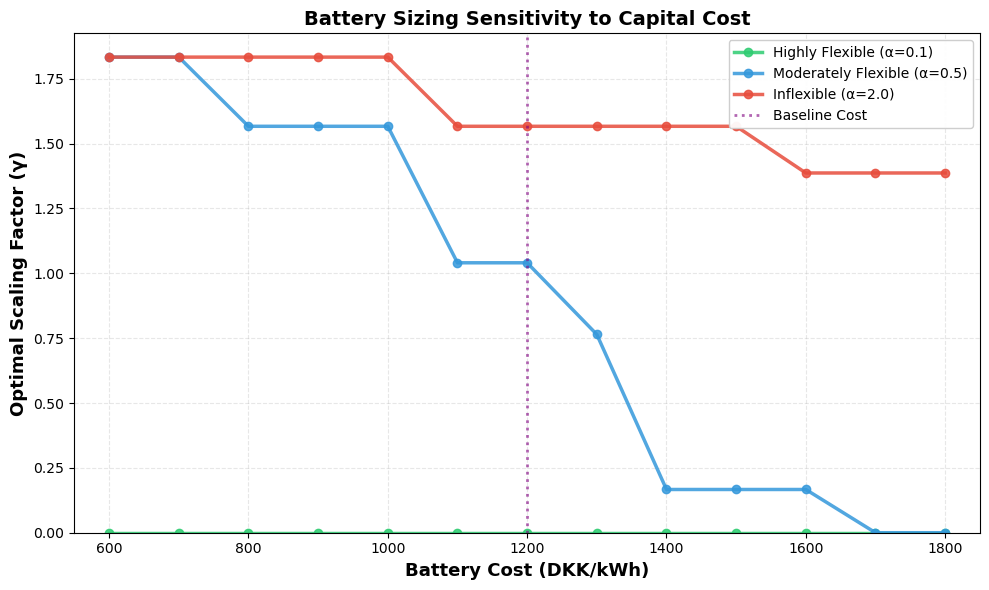

In [19]:
# Visualization: Battery cost sensitivity
# Shows how optimal battery size decreases as capital cost increases
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each consumer type
colors_sensitivity = ['#2ecc71', '#3498db', '#e74c3c']  # Green, blue, red

# Plot optimal gamma vs. battery cost for each consumer type
for idx, (alpha_val, label) in enumerate(zip(alpha_test, consumer_labels)):
    c_batts = [r['c_batt'] for r in sensitivity_results[alpha_val]]
    gammas = [r['gamma'] for r in sensitivity_results[alpha_val]]
    
    ax.plot(c_batts, gammas, marker='o', linewidth=2.5, markersize=6, 
            color=colors_sensitivity[idx], label=label, alpha=0.85)

# Add vertical line at baseline cost (1200 DKK/kWh)
ax.axvline(x=1200, color='purple', linestyle=':', linewidth=2, alpha=0.6, label='Baseline Cost')

ax.set_xlabel('Battery Cost (DKK/kWh)', fontsize=13, fontweight='bold')
ax.set_ylabel('Optimal Scaling Factor (γ)', fontsize=13, fontweight='bold')
ax.set_title('Battery Sizing Sensitivity to Capital Cost', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([550, 1850])
ax.set_ylim(bottom=0)

plt.tight_layout()

# Save figure
import os
os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
plt.savefig('./Plots/Scenarios 2)/battery_cost_sensitivity.png', dpi=300, bbox_inches='tight')

plt.show()

## Constraint Binding Analysis

Identify which constraints limit battery sizing for each consumer type: capacity (SOC), charging power, or discharging power.

In [20]:
# Function to get detailed solution with all constraints and shadow prices
# Provides comprehensive analysis of the optimization solution for debugging and insight
def solve_detailed_battery_sizing(alpha_value, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                                   D_max_val, D_ref_vals, Batt_cap_val, Batt_max_ch, Batt_max_dis,
                                   Batt_eff_ch, Batt_eff_dis, Batt_init_soc, Batt_final_soc,
                                   c_batt_val, N_batt_val, max_imp, max_exp):
    """
    Solve battery sizing optimization and return model object for detailed analysis
    
    Returns the Gurobi model object after optimization, which allows:
    - Accessing shadow prices (dual values)
    - Checking constraint binding status
    - Analyzing reduced costs
    - Sensitivity analysis on constraints
    
    Args:
        [Same as solve_battery_sizing function]
    
    Returns:
        Gurobi Model object with optimized solution
    """
    Times = range(len(elec_prices))
    
    # Create model with detailed output enabled
    m = gp.Model(f"Detailed_Battery_Sizing_alpha_{alpha_value}")
    m.setParam('OutputFlag', 1)  # Show solver output for transparency
    
    # Decision variables
    gamma_batt = m.addVar(lb=0, name="gamma_batt")
    D_t = m.addVars(Times, lb=0, ub=D_max_val, name="D_t")
    C_t = m.addVars(Times, lb=0, name="C_t")
    P_imp_t = m.addVars(Times, lb=0, ub=max_imp, name="P_imp_t")
    P_exp_t = m.addVars(Times, lb=0, ub=max_exp, name="P_exp_t")
    L_t = m.addVars(Times, lb=0, name="L_t")
    P_batt_ch = m.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = m.addVars(Times, lb=0, name="P_batt_dis")
    SOC = m.addVars(Times, lb=0, name="SOC")
    
    # Objective function
    m.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    P_exp_t[t] * (elec_prices[t] - tau_exp_val) + 
                    alpha_value * L_t[t] for t in Times) +
                    c_batt_val * (gamma_batt * Batt_cap_val) / N_batt_val,
        GRB.MINIMIZE
    )
    
    # Add all constraints (same as solve_battery_sizing)
    for t in Times:
        m.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        m.addLConstr(L_t[t] >= D_t[t] - D_ref_vals[t], name=f"discomfort_1_{t}")
        m.addLConstr(L_t[t] >= -(D_t[t] - D_ref_vals[t]), name=f"discomfort_2_{t}")
        m.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                     D_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
        m.addLConstr(P_batt_ch[t] <= Batt_max_ch * gamma_batt, name=f"batt_ch_limit_{t}")
        m.addLConstr(P_batt_dis[t] <= Batt_max_dis * gamma_batt, name=f"batt_dis_limit_{t}")
        m.addLConstr(SOC[t] <= Batt_cap_val * gamma_batt, name=f"soc_limit_{t}")
    
    m.addConstr(SOC[0] == Batt_init_soc * gamma_batt + 
                P_batt_ch[0] * Batt_eff_ch - P_batt_dis[0] / Batt_eff_dis, 
                name="SOC_0")
    
    for t in Times:
        if t > 0:
            m.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t] * Batt_eff_ch - 
                         P_batt_dis[t] / Batt_eff_dis, name=f"SOC_dynamics_{t}")
    
    m.addLConstr(SOC[len(Times)-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
    m.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref_vals), 
                 name="daily_energy_constraint")
    
    # Solve
    m.optimize()
    
    # Return the complete model object for further analysis
    return m

In [21]:
# Solve detailed model for moderately flexible consumer (alpha = 0.5)
# This provides the model object for constraint analysis
model_detailed = solve_detailed_battery_sizing(
    alpha_value=0.5,
    pv_prod=pv_prod_hourly,
    elec_prices=electricity_prices,
    tau_imp_val=tau_imp,
    tau_exp_val=tau_exp,
    D_max_val=D_max,
    D_ref_vals=D_ref,
    Batt_cap_val=Batt_cap,
    Batt_max_ch=Batt_max_ch_power,
    Batt_max_dis=Batt_max_dis_power,
    Batt_eff_ch=Batt_charging_eff,
    Batt_eff_dis=Batt_discharging_eff,
    Batt_init_soc=Batt_initial_soc,
    Batt_final_soc=Batt_final_soc,
    c_batt_val=c_batt,
    N_batt_val=N_batt,
    max_imp=max_import,
    max_exp=max_export
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 194 rows, 193 columns and 530 nonzeros
Model fingerprint: 0x85728d4c
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
Presolve removed 25 rows and 10 columns
Presolve time: 0.00s
Presolved: 169 rows, 183 columns, 497 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1030000e+04   3.582314e+03   0.000000e+00      0s
     135    2.8977926e+01   0.000000e+00   0.000000e+00      0s

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread c

In [22]:
# Analyze binding constraints
# Identifies which constraints are active (binding) at the optimal solution
# Binding constraints have slack = 0 and directly limit the objective value

print("="*90)
print("BINDING CONSTRAINT ANALYSIS")
print("="*90)
print("\nA constraint is binding if its slack is effectively zero (< 1e-6)")
print("Binding constraints are active limits that directly affect the optimal solution.\n")

# Check all constraints in the model
binding_constraints = []
non_binding_constraints = []

for constr in model_detailed.getConstrs():
    slack = abs(constr.Slack)  # Slack = 0 means constraint is binding
    
    # Classify as binding if slack is essentially zero
    if slack < 1e-6:
        binding_constraints.append({
            'name': constr.ConstrName,
            'slack': slack,
            'sense': constr.Sense,
            'rhs': constr.RHS
        })
    else:
        non_binding_constraints.append({
            'name': constr.ConstrName,
            'slack': slack
        })

# Display summary statistics
print(f"Total constraints: {len(model_detailed.getConstrs())}")
print(f"Binding constraints: {len(binding_constraints)}")
print(f"Non-binding constraints: {len(non_binding_constraints)}")

# Group binding constraints by type
constraint_types = {}
for bc in binding_constraints:
    # Extract constraint type from name (e.g., "power_balance_5" -> "power_balance")
    constraint_type = bc['name'].rsplit('_', 1)[0] if '_' in bc['name'] else bc['name']
    
    if constraint_type not in constraint_types:
        constraint_types[constraint_type] = []
    constraint_types[constraint_type].append(bc)

BINDING CONSTRAINT ANALYSIS

A constraint is binding if its slack is effectively zero (< 1e-6)
Binding constraints are active limits that directly affect the optimal solution.

Total constraints: 194
Binding constraints: 114
Non-binding constraints: 80


## Shadow Price Analysis

Shadow prices (dual variables) show the marginal value of relaxing each constraint. A higher shadow price indicates that relaxing that constraint would provide more cost reduction, revealing which constraints are truly limiting the battery sizing decision.

In [23]:
# Display binding constraints grouped by type
print("\n" + "="*90)
print("BINDING CONSTRAINTS BY TYPE")
print("="*90)

for ctype, constraints in sorted(constraint_types.items()):
    print(f"\n{ctype}: {len(constraints)} binding occurrences")
    
    # Show first few examples
    for i, bc in enumerate(constraints[:5]):  # Show max 5 examples per type
        print(f"  {bc['name']:<40} | Slack: {bc['slack']:.2e} | RHS: {bc['rhs']:.4f}")
    
    if len(constraints) > 5:
        print(f"  ... and {len(constraints) - 5} more")

# Create detailed binding constraint summary table
# Shows percentage of time each constraint type is binding
import pandas as pd

# Calculate binding percentage for time-indexed constraints
binding_summary = []

# Define constraint types that appear multiple times (hourly)
hourly_constraint_types = [
    'Curtailment',
    'discomfort_1', 
    'discomfort_2',
    'power_balance',
    'batt_ch_limit',
    'batt_dis_limit',
    'soc_limit',
    'SOC_dynamics'
]

# Count binding occurrences for each type
for ctype in hourly_constraint_types:
    # Get all constraints of this type
    matching = [bc for bc in binding_constraints if ctype in bc['name']]
    total = sum(1 for c in model_detailed.getConstrs() if ctype in c.ConstrName)
    
    if total > 0:
        binding_pct = (len(matching) / total) * 100
        binding_summary.append({
            'Constraint Type': ctype,
            'Binding Count': len(matching),
            'Total Count': total,
            'Binding %': binding_pct
        })

# Add singleton constraints (SOC_0, SOC_end, daily_energy_constraint)
singleton_types = ['SOC_0', 'SOC_end', 'daily_energy_constraint']
for ctype in singleton_types:
    matching = [bc for bc in binding_constraints if bc['name'] == ctype]
    if matching:
        binding_summary.append({
            'Constraint Type': ctype,
            'Binding Count': 1,
            'Total Count': 1,
            'Binding %': 100.0
        })
    else:
        binding_summary.append({
            'Constraint Type': ctype,
            'Binding Count': 0,
            'Total Count': 1,
            'Binding %': 0.0
        })

# Create DataFrame and display
df_binding = pd.DataFrame(binding_summary)
df_binding = df_binding.sort_values('Binding %', ascending=False)

print("\n" + "="*90)
print("BINDING CONSTRAINT SUMMARY TABLE")
print("="*90)
print(df_binding.to_string(index=False))

# Highlight key insights
print("\n" + "="*90)
print("KEY INSIGHTS")
print("="*90)

# Find most frequently binding constraints
most_binding = df_binding[df_binding['Binding %'] > 50]
if not most_binding.empty:
    print("\nFrequently binding constraints (>50% of the time):")
    for _, row in most_binding.iterrows():
        print(f"  - {row['Constraint Type']}: {row['Binding %']:.1f}%")

# Find rarely binding constraints
rarely_binding = df_binding[df_binding['Binding %'] < 10]
if not rarely_binding.empty:
    print("\nRarely binding constraints (<10% of the time):")
    for _, row in rarely_binding.iterrows():
        print(f"  - {row['Constraint Type']}: {row['Binding %']:.1f}%")


BINDING CONSTRAINTS BY TYPE

Curtailment: 9 binding occurrences
  Curtailment_0                            | Slack: 0.00e+00 | RHS: 0.0000
  Curtailment_1                            | Slack: 0.00e+00 | RHS: 0.0000
  Curtailment_2                            | Slack: 0.00e+00 | RHS: 0.0000
  Curtailment_3                            | Slack: 0.00e+00 | RHS: 0.0000
  Curtailment_4                            | Slack: 0.00e+00 | RHS: 0.0000
  ... and 4 more

SOC: 2 binding occurrences
  SOC_0                                    | Slack: 0.00e+00 | RHS: 0.0000
  SOC_end                                  | Slack: 0.00e+00 | RHS: 0.0000

SOC_dynamics: 23 binding occurrences
  SOC_dynamics_1                           | Slack: 0.00e+00 | RHS: 0.0000
  SOC_dynamics_2                           | Slack: 0.00e+00 | RHS: 0.0000
  SOC_dynamics_3                           | Slack: 0.00e+00 | RHS: 0.0000
  SOC_dynamics_4                           | Slack: 0.00e+00 | RHS: 0.0000
  SOC_dynamics_5           

In [24]:
# Function to extract and analyze shadow prices (dual values)
# Shadow prices indicate how much the objective would improve if a constraint's RHS increased by 1 unit
def analyze_shadow_prices(model):
    """
    Extract and analyze shadow prices from optimized model
    
    Shadow prices (dual values) represent the marginal value of relaxing a constraint:
    - Positive shadow price = objective decreases if RHS increases (for minimization)
    - Zero shadow price = constraint is not binding
    - Higher magnitude = more valuable to relax that constraint
    
    Args:
        model: Optimized Gurobi model object
    
    Returns:
        DataFrame with shadow price analysis
    """
    
    # Extract shadow prices for all constraints
    shadow_prices = []
    
    for constr in model.getConstrs():
        shadow_price = constr.Pi  # Dual value (shadow price)
        slack = abs(constr.Slack)
        
        # Only include constraints with non-zero shadow price (binding constraints)
        if abs(shadow_price) > 1e-6:
            shadow_prices.append({
                'Constraint': constr.ConstrName,
                'Shadow Price': shadow_price,
                'Slack': slack,
                'RHS': constr.RHS,
                'Sense': constr.Sense,
                'Binding': slack < 1e-6
            })
    
    # Create DataFrame
    df_shadow = pd.DataFrame(shadow_prices)
    
    if not df_shadow.empty:
        # Sort by absolute value of shadow price (most impactful constraints first)
        df_shadow['Abs_Shadow_Price'] = df_shadow['Shadow Price'].abs()
        df_shadow = df_shadow.sort_values('Abs_Shadow_Price', ascending=False)
        df_shadow = df_shadow.drop('Abs_Shadow_Price', axis=1)
    
    return df_shadow

# Perform shadow price analysis on the detailed model
# Identifies which constraints have the highest marginal value
df_shadow_prices = analyze_shadow_prices(model_detailed)

print("="*100)
print("SHADOW PRICE ANALYSIS")
print("="*100)
print("\nShadow Price Interpretation:")
print("  - For minimization problems, negative shadow price means relaxing constraint reduces cost")
print("  - Magnitude indicates marginal value of relaxing constraint by 1 unit")
print("  - Zero shadow price = constraint not binding (has slack)\n")

# Display top 20 most impactful shadow prices
if not df_shadow_prices.empty:
    print("Top 20 Constraints by Shadow Price Magnitude:")
    print("="*100)
    print(df_shadow_prices.head(20).to_string(index=False))
    
    # Summary statistics
    print("\n" + "="*100)
    print("SHADOW PRICE STATISTICS")
    print("="*100)
    print(f"Number of constraints with non-zero shadow price: {len(df_shadow_prices)}")
    print(f"Maximum shadow price magnitude: {df_shadow_prices['Shadow Price'].abs().max():.4f}")
    print(f"Mean shadow price magnitude: {df_shadow_prices['Shadow Price'].abs().mean():.4f}")
    
    # Group by constraint type
    print("\n" + "="*100)
    print("SHADOW PRICE SUMMARY BY CONSTRAINT TYPE")
    print("="*100)
    
    # Extract constraint types
    df_shadow_prices['Type'] = df_shadow_prices['Constraint'].apply(
        lambda x: x.rsplit('_', 1)[0] if '_' in x else x
    )
    
    # Calculate statistics by type
    type_summary = df_shadow_prices.groupby('Type').agg({
        'Shadow Price': ['count', 'mean', 'min', 'max'],
    }).round(4)
    
    print(type_summary)
else:
    print("No constraints with non-zero shadow prices found (all constraints have slack)")

SHADOW PRICE ANALYSIS

Shadow Price Interpretation:
  - For minimization problems, negative shadow price means relaxing constraint reduces cost
  - Magnitude indicates marginal value of relaxing constraint by 1 unit
  - Zero shadow price = constraint not binding (has slack)

Top 20 Constraints by Shadow Price Magnitude:
             Constraint  Shadow Price  Slack    RHS Sense  Binding
       power_balance_19      2.291346    0.0 -0.750     =     True
       power_balance_18      2.291346    0.0 -0.750     =     True
       power_balance_21      2.291346    0.0  0.000     =     True
       power_balance_20      2.291346    0.0  0.000     =     True
        SOC_dynamics_20     -2.062211    0.0  0.000     =     True
        SOC_dynamics_19     -2.062211    0.0  0.000     =     True
        SOC_dynamics_22     -2.062211    0.0  0.000     =     True
        SOC_dynamics_18     -2.062211    0.0  0.000     =     True
                SOC_end      2.062211    0.0  0.000     >     True
        

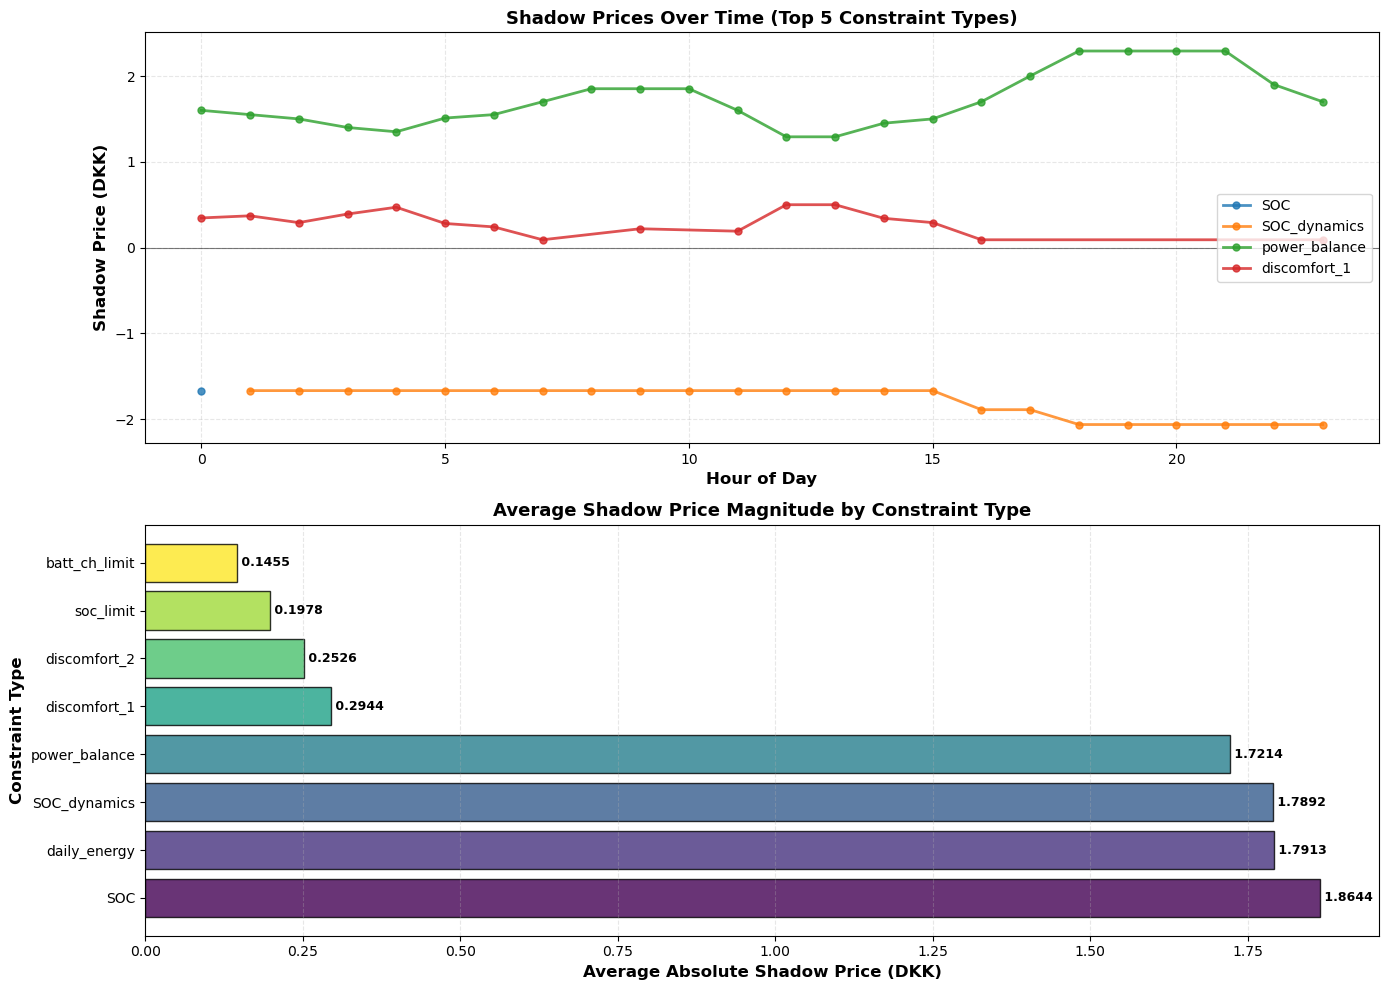

In [25]:
# Visualization: Shadow Price Analysis
# Shows which constraints have the highest marginal value across time periods
import matplotlib.pyplot as plt
import numpy as np

# Filter to show only most significant shadow prices (top constraint types)
if not df_shadow_prices.empty:
    # Get constraint types with highest average absolute shadow price
    type_avg = df_shadow_prices.groupby('Type')['Shadow Price'].apply(lambda x: x.abs().mean())
    top_types = type_avg.nlargest(5).index.tolist()
    
    # Filter data for these top types
    df_plot = df_shadow_prices[df_shadow_prices['Type'].isin(top_types)].copy()
    
    # Extract hour from constraint name (if applicable)
    def extract_hour(constraint_name):
        parts = constraint_name.split('_')
        try:
            return int(parts[-1])
        except:
            return -1
    
    df_plot['Hour'] = df_plot['Constraint'].apply(extract_hour)
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Shadow prices over time for each constraint type
    ax1 = axes[0]
    
    for ctype in top_types:
        df_type = df_plot[df_plot['Type'] == ctype]
        df_type_hourly = df_type[df_type['Hour'] >= 0].sort_values('Hour')
        
        if not df_type_hourly.empty:
            ax1.plot(df_type_hourly['Hour'], df_type_hourly['Shadow Price'], 
                    marker='o', label=ctype, linewidth=2, markersize=5, alpha=0.8)
    
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Shadow Price (DKK)', fontsize=12, fontweight='bold')
    ax1.set_title('Shadow Prices Over Time (Top 5 Constraint Types)', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # Plot 2: Average absolute shadow price by constraint type
    ax2 = axes[1]
    
    type_avg_all = df_shadow_prices.groupby('Type')['Shadow Price'].apply(lambda x: x.abs().mean()).sort_values(ascending=False)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(type_avg_all)))
    bars = ax2.barh(range(len(type_avg_all)), type_avg_all.values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_yticks(range(len(type_avg_all)))
    ax2.set_yticklabels(type_avg_all.index)
    ax2.set_xlabel('Average Absolute Shadow Price (DKK)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Constraint Type', fontsize=12, fontweight='bold')
    ax2.set_title('Average Shadow Price Magnitude by Constraint Type', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, type_avg_all.values)):
        ax2.text(value, i, f' {value:.4f}', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    import os
    os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
    plt.savefig('./Plots/Scenarios 2)/shadow_price_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("No shadow price data available for visualization")